In [1]:
from resnet_pytorch import *
from FP_layers import *
from train_classes import *
# from train_class import *

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import sys
from fitsne import FItSNE

import time
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device, 'torch.distributed.is_available():', torch.distributed.is_available())
print(device)
# torch.distributed.init_process_group()

/home/zl310/anaconda3/envs/michael/lib/python3.8/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/zl310/anaconda3/envs/michael/lib/python3.8/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


cuda:0


In [ ]:
from lin_eval import collate_data
epoch_resnet, batch_size_resnet, lr_resnet, embed_dim = 500, 4096, 4.8, 128
base_path = "./saved_models/PyTorchResNet_woDatNormalise/"
resnet_model_pth = base_path + "epoch_%d_bs_%d_lr_%g_reg_1e-06_embedDim_%d.pt" % \
                (epoch_resnet, batch_size_resnet, float(lr_resnet), embed_dim)

model = ResNet_PyTorch_wrapper(embed_dim=embed_dim, lin_eval_flag=True)
try: 
    model.load_state_dict(torch.load(resnet_model_pth, map_location={'cuda:1': device}))
except: 
    model.load_state_dict(torch.load(resnet_model_pth, map_location={'cuda:0': device}))
# model.load_state_dict(torch.load(resnet_model_pth))
model = model.to(device)

X_train, y_train, X_test, y_test = collate_data(model, device)

In [3]:
""" citation for T-SNE
@article{Linderman_Rachh_Hoskins_Steinerberger_Kluger_2019, title={Fast interpolation-based T-Sne for improved visualization of single-cell RNA-seq data}, volume={16}, DOI={10.1038/s41592-018-0308-4}, number={3}, journal={Nature Methods}, author={Linderman, George C. and Rachh, Manas and Hoskins, Jeremy G. and Steinerberger, Stefan and Kluger, Yuval}, year={2019}, pages={243–245}} 
"""
X_all_transf = FItSNE(np.concatenate((X_train, X_test), axis=0).astype(np.double))

Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 60000, K: 90, N*K = 5400000
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (112 threads):
[===========================================================>] 99% 27.383s
Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.002274)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 1.65 seconds), cost 4.977636
Iteration 100 (50 iterations in 1.74 seconds), cost 4.678752
Iteration 150 (50 iterations in 1.81 seconds), cost 4.685097
Iteration 200 (50 iterations in 

In [ ]:
def nt_xent_loss(x, temperature=0.1):
    xcs = F.cosine_similarity(x[None, :, :], x[:, None, :], dim=-1)
    # assume x has shape [batch_size*2, 64]
    xcs[torch.eye(x.size(0)).bool()] = float("-inf")

    target = torch.arange(x.size(0))
    target[0::2] += 1
    target[1::2] -= 1

    ce_loss = F.cross_entropy(xcs.to(device) / torch.tensor(temperature).to(device), target.to(device), reduction="mean")
    # Standard cross entropy loss
    # only need adjacent pairs: [2k, 2k-1] and [2k-1, 2k] for k in range(batch_size/2),
    # which is ensured by "target" (some magic happens I guess)
    return ce_loss

def add_contrastive_loss(hidden,
                         hidden_norm=True,
                         temperature=0.1):
    """Compute loss for model.

    Args:
        hidden: hidden vector (`Tensor`) of shape (2 * bsz, dim).
        hidden_norm: whether or not to use normalization on the hidden vector.
        temperature: a `floating` number for temperature scaling.
        tpu_context: context information for tpu.
        weights: a weighting number or vector.

    Returns:
        A loss scalar.
        The logits for contrastive prediction task.
        The labels for contrastive prediction task.
    """
    # Get (normalized) hidden1 and hidden2.
    # print(hidden)
    if hidden_norm:
        hidden = F.normalize(hidden, p=2, dim=1)
    batch_size = int(hidden.shape[0] / 2)
    hidden1, hidden2 = torch.split(hidden, batch_size, dim=0)

    # Gather hidden1/hidden2 across replicas and create local labels.
    
    hidden1_large = hidden1
    # print(hidden1)
    hidden2_large = hidden2
    labels = F.one_hot(torch.arange(0, batch_size), batch_size * 2)
    masks = F.one_hot(torch.arange(0, batch_size), batch_size)

    logits_aa = torch.matmul(hidden1, hidden1_large.T) / temperature
    logits_aa = logits_aa - masks * 1e9
    logits_bb = torch.matmul(hidden2, hidden2_large.T) / temperature
    logits_bb = logits_bb - masks * 1e9
    logits_ab = torch.matmul(hidden1, hidden2_large.T) / temperature
    logits_ba = torch.matmul(hidden2, hidden1_large.T) / temperature
    loss_a = F.cross_entropy(
        torch.concat([logits_ab, logits_aa], dim=1), labels.type(torch.DoubleTensor))
    loss_b = F.cross_entropy(
        torch.concat([logits_ba, logits_bb], dim=1), labels.type(torch.DoubleTensor))
    loss = loss_a + loss_b

    return loss, logits_ab, labels

bs = 512
t = 0.5
size = 64
cl_size = 10
crit = ContrastiveLoss(batch_size=bs, temperature=t)

t1, t2 = torch.ones(bs, size)*0, torch.ones(bs, size)*0
# t1, t2 = torch.rand(bs, size)*-1, torch.rand(bs, size)*-1
t3, t4 = torch.Tensor(bs*2, size), torch.Tensor(bs*2, size)

for i in range(bs):
    t1[i, i % cl_size] = 1#i*(1+torch.Tensor(np.sin(np.linspace(0, size, num=size))))
    t2[i, i % cl_size] = 1#i*(1+torch.Tensor(np.sin(np.linspace(0, size, num=size))))

t4[::2, :] = t1
t4[1::2, :] = t2
t3[:bs, :] = t1
t3[bs:, :] = t2

print(crit(t1, t2), nt_xent_loss(t4, temperature=t), t1.shape, add_contrastive_loss(t3, temperature=t)[0] / 2)

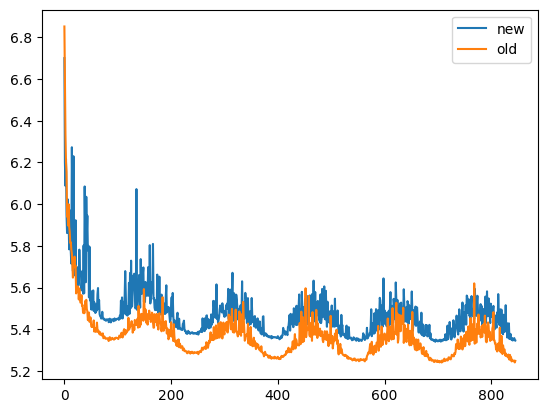

In [7]:
import matplotlib.pyplot as plt
# f_ptr = open("saved_models/max_epoch_1000_bs_4096_lr_4.8_reg_1e-06.txt")

def extract_xy(pth):
    f_ptr = open(pth, 'r')
    lines = f_ptr.readlines()
    f_ptr.close()
    first_numbers, second_numbers = [], []
    # Extract numbers and append to the lists
    for line in lines:
        parts = line.split(',')
        first_numbers.append(int(parts[0]))
        second_numbers.append(float(parts[1]))
    return first_numbers, second_numbers
# base_new = 'saved_models/wo_data_normalise/'
# base_old = 'saved_models/'
# base_old = 'saved_models/wo_data_normalise/'

# base_new = 'saved_models/w_data_normalise_nesterovTrue/'
# base_old = 'saved_models/woDatNormalise_nestTrue_Conv2dBiasTrue_lr1.5/'
base_old = 'saved_models/PyTorchResNet_woDatNormalise/'
# base_new = 'saved_models/PyTorchResNet_lr_1/'
base_new = 'saved_models/PyTorchResNet_lr_default_w_datNormalisation/'

name4096 = 'max_epoch_1000_bs_4096_lr_4.8_reg_1e-06_embedDim_128.txt'
name4096_lr1 = 'max_epoch_1000_bs_4096_lr_1_reg_1e-06_embedDim_128.txt'
name4096_dec3 = 'max_epoch_1000_bs_4096_lr_1.5_reg_1e-06_embedDim_128.txt'
name2048 = 'max_epoch_1000_bs_2048_lr_2.4_reg_1e-06_embedDim_128.txt'
name2048_dec3 = 'max_epoch_1000_bs_2048_lr_1.5_reg_1e-06_embedDim_128.txt'
name2048_lr1 = 'max_epoch_1000_bs_2048_lr_1_reg_1e-06_embedDim_128.txt'
name1024 = 'max_epoch_1000_bs_1024_lr_1.2_reg_1e-06_embedDim_128.txt'
name512 = 'max_epoch_1000_bs_512_lr_0.6_reg_1e-06_embedDim_128.txt'

fig, ax = plt.subplots(1, 1)
o1, o2 = extract_xy(base_old + name4096)
n1, n2 = extract_xy(base_new + name4096)
# ax.plot(n1, n2)
ax.plot(n1[0:min(len(n1), len(o1))], n2[0:min(len(n1), len(o1))], label='new')
ax.plot(o1[0:min(len(n1), len(o1))], o2[0:min(len(n1), len(o1))], label='old')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1)

o1, o2 = extract_xy(base_old + name2048)
n1, n2 = extract_xy(base_new + name2048)
# ax.plot(n1, n2, label='new')
# ax.plot(o1, o2, label='old')
ax.plot(n1[0:min(len(n1), len(o1))], n2[0:min(len(n1), len(o1))], label='new')
ax.plot(o1[0:min(len(n1), len(o1))], o2[0:min(len(n1), len(o1))], label='old')
ax.legend()

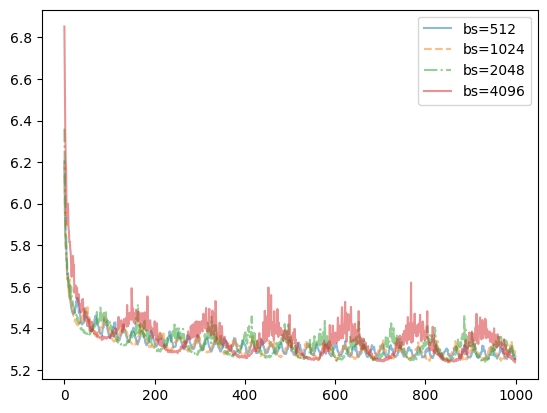

In [8]:
fig, ax = plt.subplots(1, 1)

o1_512, o2_512 = extract_xy(base_old + name512)
o1_1024, o2_1024 = extract_xy(base_old + name1024)
o1_2048, o2_2048 = extract_xy(base_old + name2048)
o1_4096, o2_4096 = extract_xy(base_old + name4096)

max_len = min([len(o1_512), len(o1_1024), len(o1_2048), len(o1_4096)])
# max_len = min([len(o1_1024), len(o1_2048), len(o1_4096)])
ax.plot(o1_512[0:max_len], o2_512[0:max_len], '-', alpha=0.5, label='bs=512')
ax.plot(o1_1024[0:max_len], o2_1024[0:max_len], '--', alpha=0.5, label='bs=1024')
ax.plot(o1_2048[0:max_len], o2_2048[0:max_len], '-.', alpha=0.5, label='bs=2048')
ax.plot(o1_4096[0:max_len], o2_4096[0:max_len], '-', alpha=0.5, label='bs=4096')
ax.legend()
